In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf ##  Autocorrelation plot
import pystan_utils
import pystan

In [2]:
df=pd.read_csv("pickups+weather_wallstreet.csv")
df.head()

,datetime,pickups,date,min_temp,max_temp,wind_speed,wind_gust,visibility,pressure,precipitation,snow_depth,fog,rain_drizzle,snow_ice,thunder
0,2009-01-01 00,47,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
1,2009-01-01 01,74,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
2,2009-01-01 02,79,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
3,2009-01-01 03,57,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0
4,2009-01-01 04,46,2009-01-01,15.1,26.1,11.6,32.1,10.0,1015.5,0.04,0.0,0,0,0,0


### Data preparation

In [4]:
## data type
df.dtypes

datetime          object
pickups            int64
date              object
min_temp         float64
max_temp         float64
wind_speed       float64
wind_gust        float64
visibility       float64
pressure         float64
precipitation    float64
snow_depth       float64
fog                int64
rain_drizzle       int64
snow_ice           int64
thunder            int64
dtype: object

In [5]:
## Convert datetime column into datetime object
df["datetime"]=pd.to_datetime(df["datetime"],format="%Y-%m-%d")

## Adding columns with day of week(dow) and time of day(tod)
df["dow"]=df.datetime.dt.weekday
df["tod"]=df.datetime.dt.hour

## Adding time of day and day of week as dummy variables
dummy_week=pd.get_dummies(df["dow"])
dummy_hour=pd.get_dummies(df["tod"])
week_colName = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
dummy_week.set_axis(week_colName, axis=1, inplace=True)

new_df=pd.concat([df, dummy_week,dummy_hour],axis=1).set_index("datetime").drop(["date","tod","dow"],axis=1)
print(new_df.shape)
print(new_df.columns)

(65712, 44)
Index([      'pickups',      'min_temp',      'max_temp',    'wind_speed',
           'wind_gust',    'visibility',      'pressure', 'precipitation',
          'snow_depth',           'fog',  'rain_drizzle',      'snow_ice',
             'thunder',        'Monday',       'Tuesday',     'Wednesday',
            'Thursday',        'Friday',      'Saturday',        'Sunday',
                     0,               1,               2,               3,
                     4,               5,               6,               7,
                     8,               9,              10,              11,
                    12,              13,              14,              15,
                    16,              17,              18,              19,
                    20,              21,              22,              23],
      dtype='object')


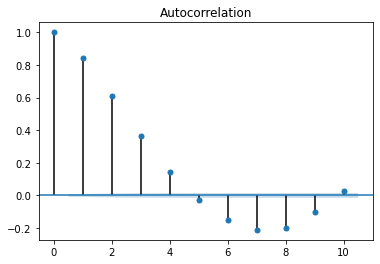

In [6]:
## Autocorrelation plot: how many lags should be included ...?
plot_acf(new_df.pickups,lags=10);

## Adding first and second lagged_pickups to the dataset
new_df["first_lag"]=new_df.pickups.shift(1)
new_df["second_lag"]=new_df.pickups.shift(2)
new_df.dropna(inplace=True)

In [7]:
new_df.shape

(65710, 46)

In [8]:
## Seperating predictors and target variable
X=new_df.drop("pickups",axis=1).values
y=new_df["pickups"].values

In [9]:
## The first 2/3 as train set and rest 1/3 as test set
N,D = X.shape
split = int(N*2/3)
X_train = X[:split,:]; X_test = X[split:, :]
y_train = y[:split]; y_test = y[split:]

In [11]:
# funciton for evaluating the quality of the predictions of a regression model (continuous output variables!)
def compute_error(trues, predicted):
    trues=trues.flatten()
    predicted=predicted.flatten()
    corr = np.corrcoef(predicted, trues)[0,1]
    mae = np.mean(np.abs(predicted - trues))
    rae = np.sum(np.abs(predicted - trues)) / np.sum(np.abs(trues - np.mean(trues)))
    rmse = np.sqrt(np.mean((predicted - trues)**2))
    r2 = max(0, 1 - np.sum((trues-predicted)**2) / np.sum((trues - np.mean(trues))**2))
    return corr, mae, rae, rmse, r2

### Plate notation

![title](PGM_Poisson.png)

### Stan model : Poisson linear regression model

In Gaussion linear regression, we assumed that the target variable $y$ is Gaussian distributed. However, this might not be the most reasonable choice. Where are modeling the number of taxi pickups (counts!). Perhaps a much more reasonable likelihood is the Poisson distribution:

$y_n \sim \mbox{Poisson}(\exp(\alpha + \boldsymbol\beta^T \textbf{x}_n))$

Notice that we included a log link function to ensure that the rate of the Poisson (the parameter of the Poisson) is non-negative, as required by the definition of the Poisson.

Lets implement this model in STAN!

Hint: STAN offers a more numerically stable version of a Poisson distribution with a log link function (when compared to a naive implementation). Check out the function "poisson_log()" in the documentation!

In [12]:
STAN_Poisson_model = """
data {
    int<lower=1> N;                  // no. of data items
    int<lower=1> D;                  // no. of predictors
    int y[N];                        // target variable
    vector[D] X[N];                  // predictor matrix 
}
parameters {
    real alpha;                      // intercept
    vector[D] beta;                  // coefficients for predictors 
}

model {    
    // Important: In STAN, the second parameter of “normal(0, 10)" is a standard
    // deviation and not a variance! So, the variance is actually 10^2 = 100
    alpha ~ normal(0,10);            // prior on the intercept
    beta ~ normal (0,1);            // prior on the coefficients
    for (i in 1:N)                   // likelihood
        // y[i] ~ poisson_log(alpha + beta'*X[i,:]);          //  equal to : y[i] ~ poisson(exp(alpha + beta'*X[i,:]))
        y[i] ~ poisson(log(1+exp(alpha + beta'*X[i,:])));     // using softplus transformation
 }

"""

# compile model
sm = pystan.StanModel(model_code = STAN_Poisson_model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_491e1dc45f91dacf49ab3716f6db9aba NOW.


### Inference on the model using MCMC (NUTS) on a small subsample of the dataset

In [35]:
# prepare data for Stan model
X_train_small = X_train[:5000,:]
y_train_small = y_train[:5000]
N, D = X_train_small.shape
data = {'N': N, 'D': D, 'X': X_train_small, 'y': y_train_small.astype(int)}

In [36]:
%%time
# create Stan model object
sm = pystan.StanModel(model_code = STAN_Poisson_model)
fit = sm.sampling(data=data, iter=1000, chains=2, algorithm="NUTS", seed=42, verbose=True)
print(fit)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_491e1dc45f91dacf49ab3716f6db9aba NOW.


Inference for Stan model: anon_model_491e1dc45f91dacf49ab3716f6db9aba.
2 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=1000.

           mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
alpha      2.16    0.36   7.84   -13.7   -3.06   1.98   7.23  18.49    479    1.0
beta[1]    0.05  8.7e-4   0.02    0.01    0.04   0.05   0.06   0.09    483   1.01
beta[2]   -0.05  7.4e-4   0.02   -0.08   -0.06  -0.05  -0.03  -0.02    488   1.02
beta[3]   -0.07  1.6e-3   0.05   -0.17    -0.1  -0.07  -0.04   0.04    986    1.0
beta[4]    0.01  7.0e-4   0.02   -0.04 -4.8e-3   0.01   0.03   0.06   1185    1.0
beta[5]    0.02  2.8e-3   0.07   -0.12   -0.02   0.02   0.07   0.16    659    1.0
beta[6]    0.01  3.6e-4 7.7e-3 -2.1e-3  8.5e-3   0.01   0.02   0.03    463    1.0
beta[7]     0.1  9.5e-3   0.33   -0.54   -0.13    0.1   0.33   0.76   1200    1.0
beta[8]    0.07  3.1e-3   0.09    -0.1    0.01   0.07   0.14   0.25    824 

Plot the posterior distribution of some of the latent variables in the model (alpha, betas and sigma)

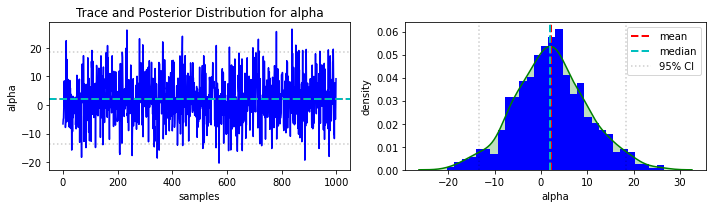

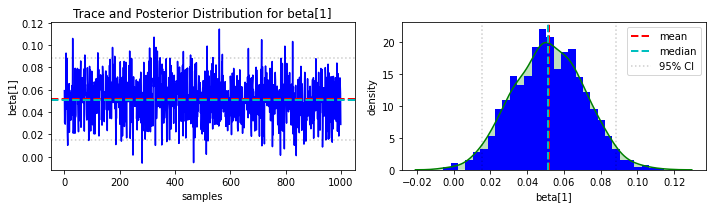

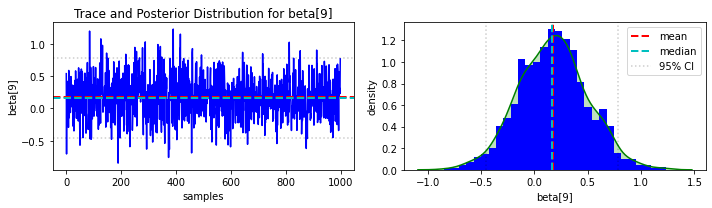

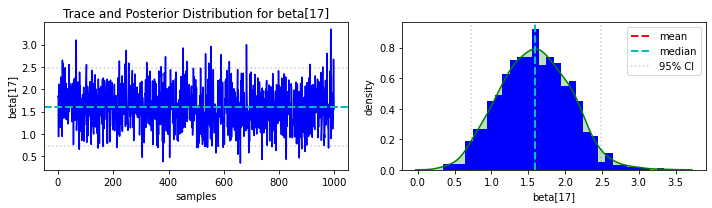

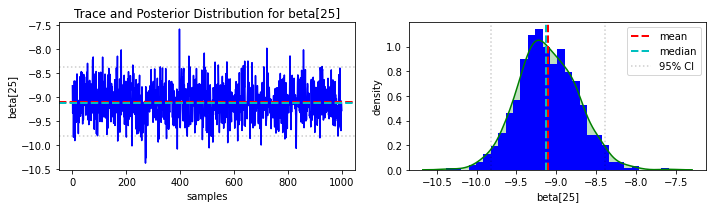

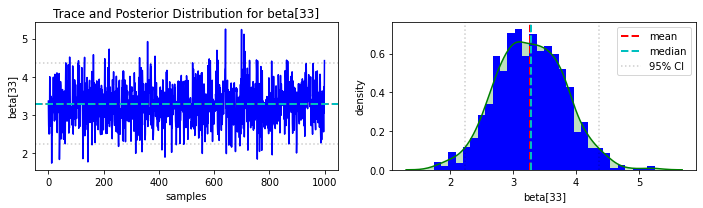

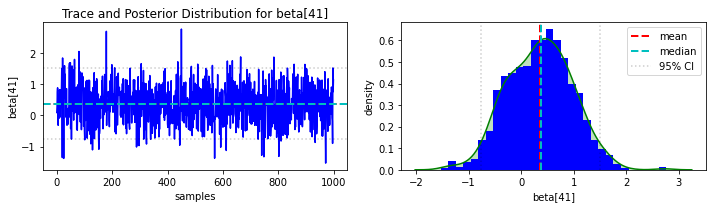

In [42]:
plt.rcParams["figure.figsize"]=(10,3)
pystan_utils.plot_trace(fit["alpha"],"alpha")
plt.show()
for i in range(1,D,8):
    pystan_utils.plot_trace(fit["beta[%d]"%i],"beta[%d]"%i)
    plt.show()    

#### Extract results and compute error statistics:

Using the estimated values, we can make predictions for the test set:

In [43]:
samples =fit.extract(permuted=True)
alpha = samples["alpha"]
beta = samples["beta"]

In [44]:
y_hat = np.log(1+np.exp(np.mean(samples["alpha"].T + np.dot(X_test, samples["beta"].T), axis=1)))
y_hat

preds = y_hat 
y_true = y_test 

corr, mae, rae, rmse, r2 = compute_error(y_true, preds)
print("CorrCoef: %.3f\nMAE: %.3f\nRMSE: %.3f\nR2: %.3f" % (corr, mae, rmse, r2))


CorrCoef: 0.907
MAE: 14.645
RMSE: 19.550
R2: 0.819


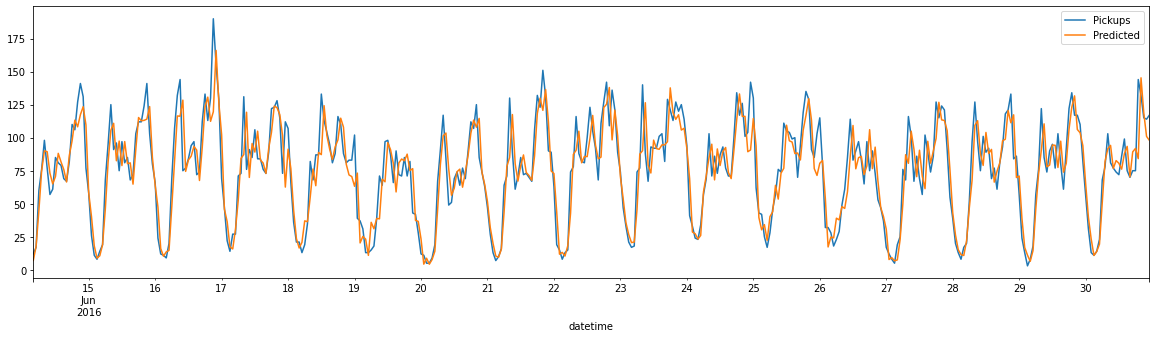

In [45]:
test_dataset = pd.DataFrame({"Pickups":y_true.flatten(),"Predicted":preds}).set_index(new_df.index[split:])
test_dataset.iloc[21500:,:].plot(figsize=(20,5));